# Lesson 3: Saving and Scripting
Author: Rebekah Esmaili (rebekah.esmaili@gmail.com)
 
---

## Lesson Objectives
* You will learn to:
    * Save data into text and binary files, and plots as images
    * Run python scripts

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

## Data Sources

### Data Archives

Most Earth-science agencies openly and freely disseminate satellite, model, and in situ observations. Typically, data are stored in online data repositories and data holdings can be queried and ordered. Some examples are shown below.

* [NASA](https://www.earthdata.nasa.gov/learn/find-data)
* [NOAA](https://www.avl.class.noaa.gov/saa/products/welcome)
* [ECMWF](https://www.ecmwf.int/en/forecasts/datasets)
* [ESA](https://earth.esa.int/eogateway/catalog)

### OPeNDAP/THREDDS catalogs

Increasingly agencies are offering data catalogs that allow users to directly read from the archive without ordered. Open-source Project for a [Network Data Access Protocol (OPeNDAP)](https://www.opendap.org/) is an example of a software tool that simplifies access. Instead of downloading and reading data into Python, we can access it directly using a URL. Xarray supports OPeNDAP.

Here are a couple of useful data OPeNDAP catalogs:

* [NOAA/Physical Sciences Lab](https://psl.noaa.gov/data/) gridded climate datasets extending hundreds of years to real-time wind profiler data at a single location. The data or products derived from this data, organized by type, are available to scientists and the general public at the links below.
* [NASA EOSDIS OpeNDAP Servers](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap/opendap-servers) servers across the Earth Observing System Data and Information System (EOSDIS). Contains many NASA satellite and reanalysis datasets.

The example below shows Level 3 Monthly Average Chlorophyll Concentration from the Ocean Biology Processing Group (NASA/GSFC/OBPG). As you can see, we are passing a url and not a file location into xarray. One caveat if the engine **must be netcdf4** because the h5netcdf engine presently doesn't support opendap.

In [27]:
url = 'http://oceandata.sci.gsfc.nasa.gov/opendap/Merged_ATV/L3SMI/2022/001/X20220012022031.L3m_MO_CHL_chlor_a_4km.nc'
sst_opendap = xr.open_dataset(url, engine='netcdf4')
sst_opendap

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    palette  (rgb, eightbitcolor) int8 ...
    chlor_a  (lat, lon) float32 ...
Attributes: (12/61)
    product_name:                     X20220012022031.L3m_MO_CHL_chlor_a_4km.nc
    project:                          Ocean Biology Processing Group (NASA/GS...
    temporal_range:                   month
    processing_version:               2018.1
    date_created:                     2022-04-02T00:25:50.000Z
    l2_flag_names:                    ATMFAIL,LAND,HILT,HISATZEN,STRAYLIGHT,C...
    ...                               ...
    data_minimum:                     0.0037206297
    data_maximum:                     99.93918
    history:                          l3mapgen par=X20220012022031.L3m_MO_CHL...
    title:                            Level-3 Mapped Data
    instrument:                       MODIS,VIIRS
    platform:                         Aqua,Terra,SNPP

In [34]:
chlor_a = sst_opendap.chlor_a[::15, ::15]
chlor_a

<xarray.DataArray 'chlor_a' (lat: 288, lon: 576)>
[165888 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.98 89.35 88.73 88.1 ... -87.52 -88.15 -88.77 -89.4
  * lon      (lon) float32 -180.0 -179.4 -178.7 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0

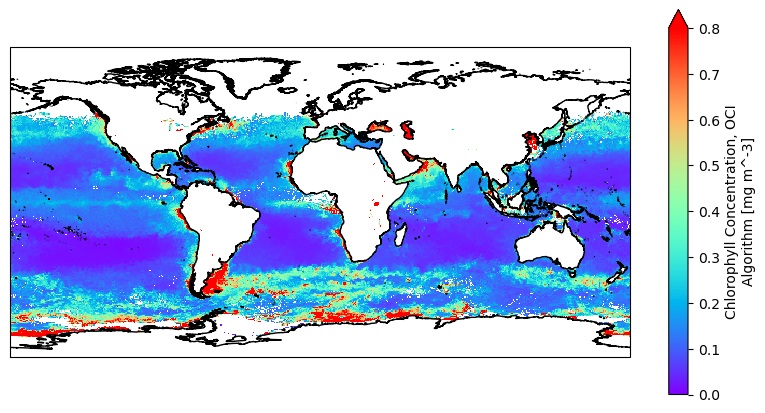

In [35]:
map_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=map_proj)
chlor_a.plot(vmin=0, vmax=.8, transform=map_proj, cmap='rainbow')
ax.coastlines("10m", color="k")

plt.show()



### Accessing data from the cloud

Many major cloud computing companies, such as Google, Microsoft, and Amazon disseminate Earth science datasets. For instance, AWS supports an [open data program](https://aws.amazon.com/opendata/) that makes many climate datasets publicly available.

The package s3fs is file interface for Amazon S3 (Simple Storage Service) buckets, so you can browse and search for data. NOAA's Open Data Dissemination (NODD) program is increasing access to satellite data, including GOES and JPSS. In this example, we'll look at GOES-16 data.

In [37]:
import s3fs

In [38]:
fs = s3fs.S3FileSystem(anon=True)
url = 'noaa-goes16/ABI-L2-RSRF/2022/285/18/OR_ABI-L2-RSRF-M6_G16_s20222851800206_e20222851809514_c20222851901446.nc'
remote_obj = fs.open(url, mode='rb')

In [39]:
# Open
g16 = xr.open_dataset(remote_obj, engine='h5netcdf')

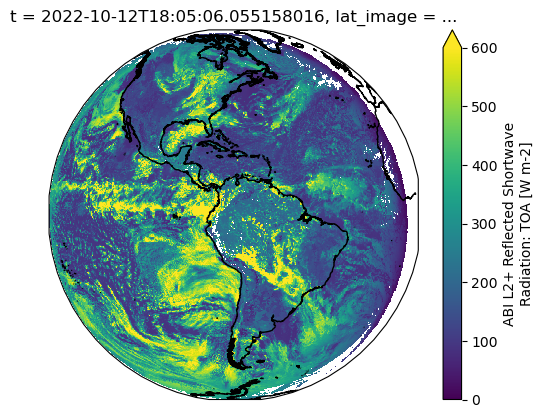

In [40]:
data_proj = ccrs.PlateCarree()
map_proj = ccrs.Orthographic(central_longitude=-72.3)

fig = plt.figure()
ax = plt.subplot(projection=map_proj)
g16.RSR.plot(transform=data_proj, vmin=0, vmax=600)
ax.coastlines("10m", color="k")

plt.show()


## Exporting data and figures


### Saving figures

Normally, we end out plots with *plt.show()* to display them inline. Instead, use *plt.savefig()*. The second argument (*bbox_inches*) refers to the whitespace around the plot, it is optional.  

In [41]:
data_proj = ccrs.PlateCarree()
map_proj = ccrs.Orthographic(central_longitude=-72.3)

fig = plt.figure()
ax = plt.subplot(projection=map_proj)
g16.RSR.plot(transform=data_proj, vmin=0, vmax=600)
ax.coastlines("10m", color="k")

# The only difference is this...
plt.savefig('SRB.png')
plt.close()


### Saving csv files

The Pandas *to_csv* is convenient for quickly saving files. The option *index=False* suppress the indices of the DataFrame (which are printed to the left of the DataFrame) from being printed to file.

In [ ]:
name = ['GOES-16', 'IceSat-2', 'Himawari']
agency = ['NOAA', 'NASA', 'JAXA']
orbit = ['GEO', 'LEO', 'GEO']

df = pd.DataFrame({'name': name,
                   'agency': agency,
                   'orbit': orbit})

df.to_csv('satellites.csv', index=False)

### Saving as a binary file

NumPy binary files (.npz) are geared towards arrays, which can be multi-dimensional. These are useful for quickly storing large datasets.

In [ ]:
np.savez('satnames', name=name, agency=agency, orbit=orbit)

In [ ]:
npzfile = np.load('satnames.npz')
npzfile.files
npzfile.close()

## Scripting with Python

### Creating scripts from Jupyter Notebooks
One of the simplest ways to create a script is to convert an existing Jupyter notebook. As an example, we will created a notebook named script_example that only contains one line of code: print(“Hello Earth”). You can convert any Jupyter Notebook to a script by going to File → Download as → Python (.py):
 

This will download a new file (script_example.py) to your computer. If you open the file using your text editor, you will see:

```

#!/usr/bin/env python
# coding: utf-8

# In[1]:

print("Hello Earth")
```

You will notice that the script contains the line numbers (*ln\[1\]*), which in my opinion is unnecessary and should be removed from your script. Beginners, you can delete this extra formatting from your file.

### Running Python scripts from the command line

Now you are finished editing the code and you probably want to run it. There are two ways you can run Python scripts:

1. Using the command line interpreter
2. Using iPython

iPython is an interactive command line that allows you to run code in chunks. In fact, Jupyter Notebook is built using iPython, which explains the similarity in behavior.
 
* Windows: I suggest using the Anaconda Prompt which you can access from the start menu or using Anaconda Navigator. 
* MacOs/Linux: open the Terminal app. 

Once the command line is open, you start in a default location. For example, if you are using Windows and launch the Anaconda Prompt you will see:

```
(base) C:\Users\rebekah>
```

Now, navigate to where our script is. To do this, you will change directories using the cd command. For example, if your code is stored in C:\Documents\Python, you can type:

```

cd C:\Documents\Python
```

The command line will now be updated showing:

```
(base) C:\Documents\Python>
```

Now that you are in the right place, you can call the Python interpreter, which to convert your code into a format that your computer can understand and executes the command. If you installed Anaconda, this includes a Python 3 interpreter (*python3*). So, to run the script, type:

```
python3 hello_world.py
```

If successful, “Hello Earth” should print to your screen.

A second method is to use iPython, which allows you to open Python in interactive mode. Unlike the command line method, iPython will let you run code line-by-line. So, like Jupyter Notebook, you have the option to copy and paste you code from the text editor in chunks into the iPython window. You can also call the entire script inside iPython. This is done by starting iPython and using the command %run \[script name\].py. Below is a capture from my terminal:

```
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Type 'copyright', 'credits' or 'license' for more information
IPython 7.12.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: %run script_example.ipynb
Hello Earth
```

One advantage of using iPython is that after the script finishes running, variables that were generated in the script are still in memory. Then, you can print or operate on the variables to either debug or to develop your code further. 

You may have noted two differences in workflow for write code in scripts versus notebooks, (1) that code cannot be inline and (2) the program must run fully to the end.


### Handling output when scripting

In the previous example, you printed text to the screen but Python’s capable of saving figures and data. To save plots, replace *plt.show()* with the *plt.savefig()* command.

It is possible to directly display your graphics using the X11 protocol (by default in Linux) with XQuartz (Mac) or PuTTy (Windows). 

I typically discourage this because satellite imagery tends to be very large and thus slow to display remotely. From my experience, it is usually faster to write an image to a file and then view the plot after it is fully rendered.

## Summary:

You learned:

* How to save data and graphics
* How to run scripts

## Conclusion

I hope you feel empowered find relevant satellite data for your project are equipped with the tools to visualize it. Practice regularly (daily!) to improve your skills. Here are some ways you can continue your journey:

* Downlaod data. You can access data from ESA (https://earth.esa.int/eogateway/), NOAA’s threads data server: https://www.ncei.noaa.gov/thredds/catalog.html, or NASA's [Earthdata](https://earthdata.nasa.gov/) portals.
* Read. 
    * [Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/) (free)
    * [Research Software Engineering with Python](https://merely-useful.tech/py-rse/) Free eBook to enhance your workflow
    * Python Programming and Visualization for Scientists by Alex DeCaria (not free)
    * Python Machine Learning by Wei-Meng Lee (not free)
    * [Earth Observation Using Python](https://www.wiley.com/en-us/Earth+Observation+using+Python%3A+A+Practical+Programming+Guide-p-9781119606888) by Rebekah Esmaili (not free)
* Watch.
    * [CS Dojo](https://www.youtube.com/channel/UCxX9wt5FWQUAAz4UrysqK9A) on YouTube has a lot of short, fun Python tutorials.
    * [Coursera](https://www.coursera.org/learn/interactive-python-1?specialization=computer-fundamentals) has some fundamental interactive Python courses if you want more structure.
    * [Python for Climate and Meteorology](https://www.youtube.com/watch?v=uQZAEPnUZ5o) Another focused Python workshop taught at AMS, a little more advanced.
* Connect with an online community, such as Pangeo (https://discourse.pangeo.io/)